In [1]:
import os
import warnings
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Load dataset
df = pd.read_csv("/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv")
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [2]:
# Unique classes of plants
df["label"].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

<Axes: xlabel='ph', ylabel='Density'>

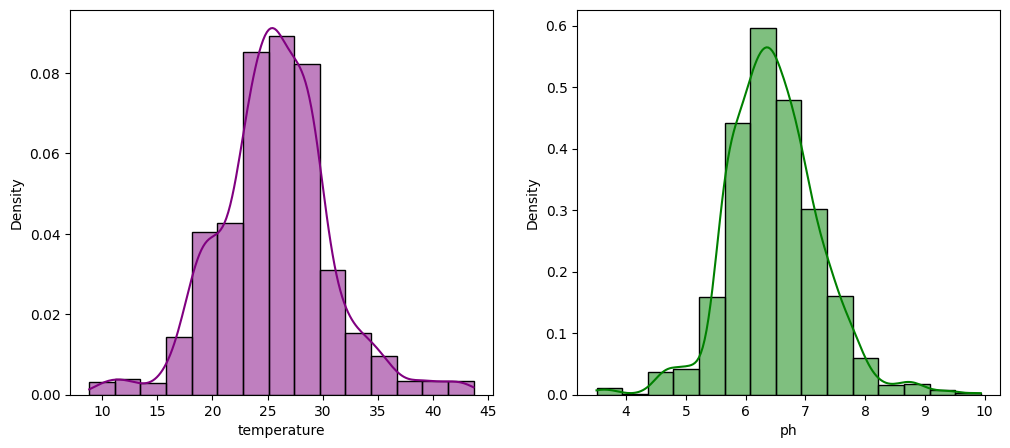

In [3]:
# Plot distribution of temperature and ph
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.histplot(df["temperature"], bins=15, color="purple", kde=True, stat="density")
plt.subplot(1, 2, 2)
sns.histplot(df['ph'], color="green", bins=15, kde=True, stat="density")

<Axes: xlabel='count', ylabel='label'>

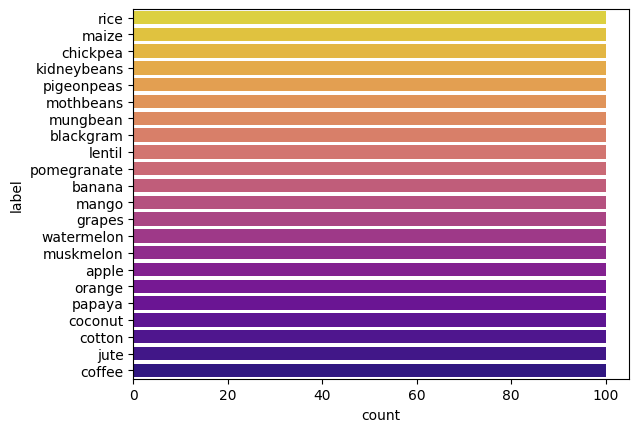

In [4]:
sns.countplot(y='label',data=df, palette="plasma_r")

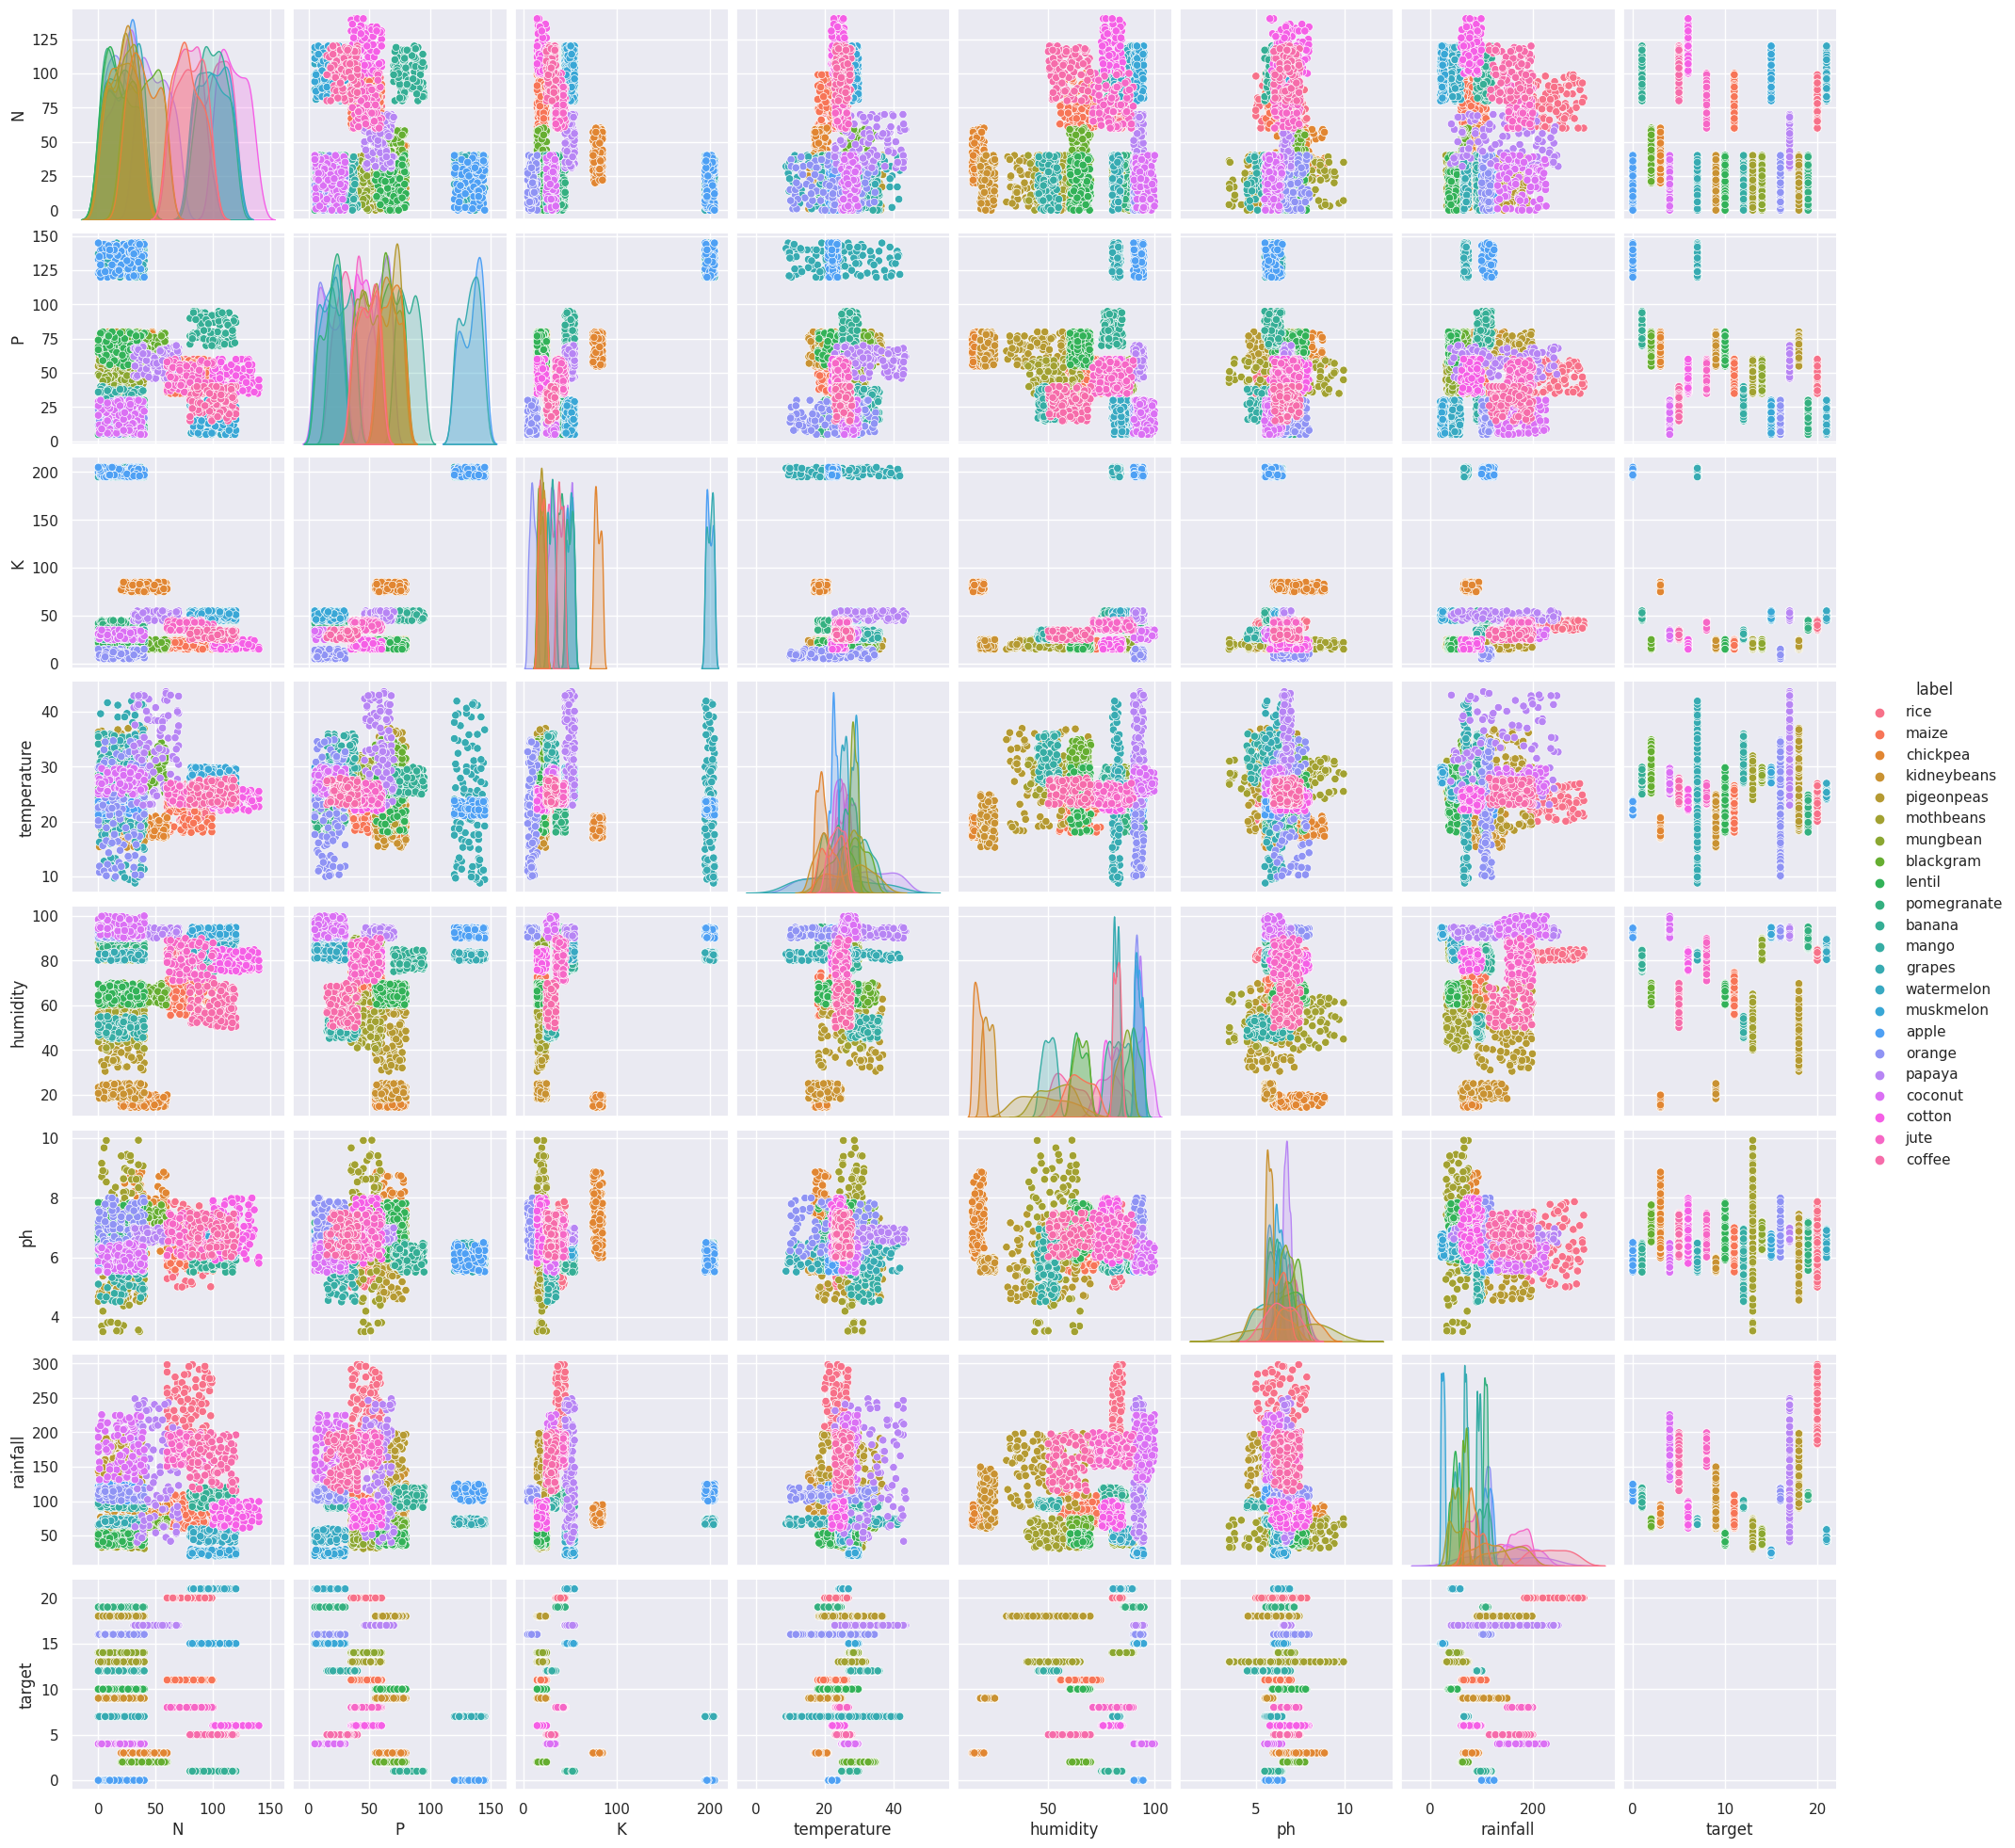

In [29]:
#distplot to see correlation between two variables
sns.pairplot(df, hue = 'label')

In [5]:
# Convert labels to categorical codes
c = df.label.astype('category')
targets = dict(enumerate(c.cat.categories))
df['target'] = c.cat.codes

c.cat.categories

Index(['apple', 'banana', 'blackgram', 'chickpea', 'coconut', 'coffee',
       'cotton', 'grapes', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango',
       'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas',
       'pomegranate', 'rice', 'watermelon'],
      dtype='object')

In [6]:
# Split dataset into features and target variable
y = df.target
X = df[['N','P','K','temperature','humidity','ph','rainfall']]

In [7]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
pickle.dump(scaler, open("/kaggle/working/crop_recommendation_scaler.pkl", "wb"))

In [8]:
# K-Nearest Neighbors classifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn_score = knn.score(X_test_scaled, y_test)
print(f"KNN Accuracy: {knn_score:.4f}")

KNN Accuracy: 0.9782


<Axes: >

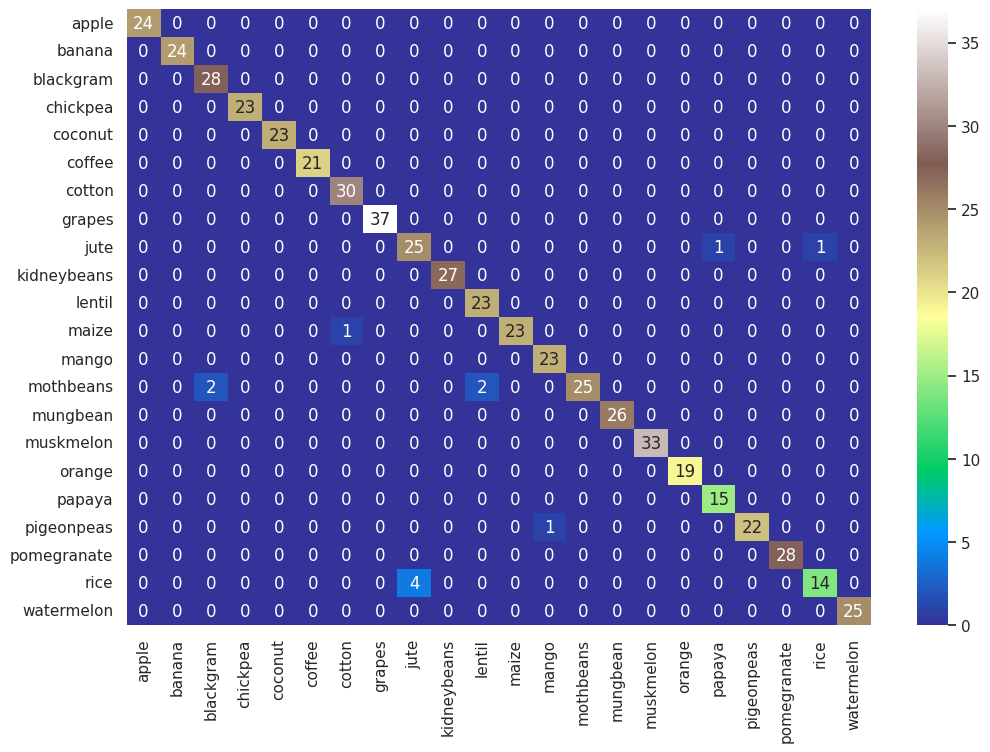

In [9]:
# Confusion matrix for KNN
mat = confusion_matrix(y_test, knn.predict(X_test_scaled))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0)
plt.figure(figsize=(12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="terrain")

([<matplotlib.axis.XTick at 0x7a6881451a80>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

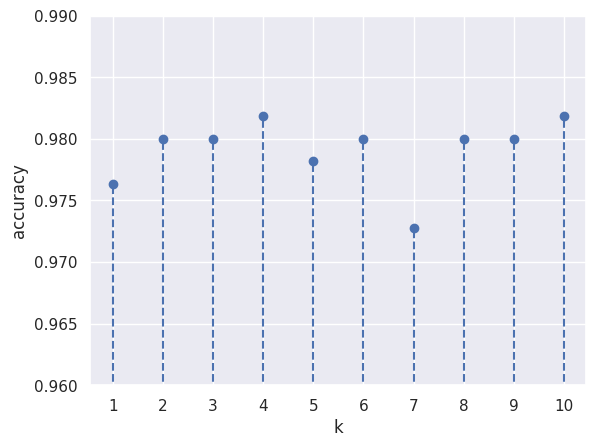

In [10]:
# Selecting best k for KNN
k_range = range(1, 11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))
    
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range, 0, scores, linestyle="dashed")
plt.ylim(0.96, 0.99)
plt.xticks([i for i in range(1, 11)])

In [11]:
# Support Vector Machine classifiers
svc_linear = SVC(kernel="linear").fit(X_train_scaled, y_train)
print(f"Linear Kernel Accuracy: {svc_linear.score(X_test_scaled, y_test):.4f}")

svc_rbf = SVC(kernel='rbf').fit(X_train_scaled, y_train)
print(f"Rbf Kernel Accuracy: {svc_rbf.score(X_test_scaled, y_test):.4f}")

svc_poly = SVC(kernel='poly').fit(X_train_scaled, y_train)
print(f"Poly Kernel Accuracy: {svc_poly.score(X_test_scaled, y_test):.4f}")

Linear Kernel Accuracy: 0.9745
Rbf Kernel Accuracy: 0.9873
Poly Kernel Accuracy: 0.9891


In [12]:
# Parameter tuning for SVM model
parameters = {'C': np.logspace(-3, 2, 6).tolist(), 'gamma': np.logspace(-3, 2, 6).tolist(), 'kernel': ["rbf", "poly"]}
model = GridSearchCV(estimator=SVC(), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'gamma': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'kernel': ['rbf', 'poly']})

In [13]:
print(f"Best SVM Score: {model.best_score_:.4f}")
print(f"Best SVM Parameters: {model.best_params_}")

Best SVM Score: 0.9915
Best SVM Parameters: {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}


In [14]:
# Random Forest Classifier
clf = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=42).fit(X_train_scaled, y_train)
print(f"RF Accuracy on training set: {clf.score(X_train_scaled, y_train):.4f}")
print(f"RF Accuracy on test set: {clf.score(X_test_scaled, y_test):.4f}")

print(classification_report(y_test, clf.predict(X_test_scaled)))

RF Accuracy on training set: 0.9715
RF Accuracy on test set: 0.9727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       0.78      1.00      0.88        28
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        37
           8       0.92      0.89      0.91        27
           9       1.00      1.00      1.00        27
          10       0.92      1.00      0.96        23
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        23
          13       1.00      0.66      0.79        29
          14       1.00      1.00      1.00        26
          15       1.00      1.00      1.00        33
          16 

In [15]:
# XGBoost model with GridSearchCV for parameter tuning
parameters = {'max_depth': [4, 5, 6], 'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 100, 1000]}
model = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=parameters, n_jobs=-1, cv=4)
model.fit(X_train_scaled, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [4, 5, 6],
                         'n_estimators': [10, 100, 1000]})

In [16]:
print(f"Best XGBoost Score: {model.best_score_:.4f}")
print(f"Best XGBoost Parameters: {model.best_params_}")

Best XGBoost Score: 0.9855
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 1000}


In [17]:
#training the SVM model on all the available data
X_scaled = scaler.transform(X)
#{'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
svm_model = SVC(C = 10, gamma = 10, kernel = 'rbf')
svm_model.fit(X_scaled , y)
svm_model.score(X_scaled, y)

0.9959090909090909

In [20]:
pickle.dump(svm_model, open("crop_recommendation_svm.keras", "wb"))

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [22]:
# Build a simple neural network in Keras
model = keras.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled.shape[1],)), # input layer
    layers.Dense(64, activation='relu'), # hidden layer
    layers.Dense(32, activation='relu'), # hidden layer
    layers.Dense(len(targets), activation='softmax') # output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0535 - loss: 3.0564 - val_accuracy: 0.1709 - val_loss: 2.9157
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2271 - loss: 2.8575 - val_accuracy: 0.3218 - val_loss: 2.5953
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4047 - loss: 2.4992 - val_accuracy: 0.4491 - val_loss: 2.1393
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5085 - loss: 2.0549 - val_accuracy: 0.6182 - val_loss: 1.7135
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6417 - loss: 1.6688 - val_accuracy: 0.7218 - val_loss: 1.4005
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7447 - loss: 1.3397 - val_accuracy: 0.8164 - val_loss: 1.1523
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8137 - loss: 1.0964 - val_accuracy: 0.8382 - val_loss: 0.9661
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8400 - loss: 0.9444 - val_accuracy: 0.8600 - val_loss:

In [23]:
# Save the model in .keras format
model.save("crop_recommendation_model.keras")

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0837 - loss: 3.0995 - val_accuracy: 0.0436 - val_loss: 3.0426
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2466 - loss: 2.4265 - val_accuracy: 0.0727 - val_loss: 2.9241
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4117 - loss: 2.0213 - val_accuracy: 0.1909 - val_loss: 2.7278
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5143 - loss: 1.6863 - val_accuracy: 0.2273 - val_loss: 2.4384
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5783 - loss: 1.3912 - val_accuracy: 0.3691 - val_loss: 2.0399
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6423 - loss: 1.1743 - val_accuracy: 0.5800 - val_loss: 1.6134
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6814 - loss: 1.0075 - val_accuracy: 0.6473 - val_loss: 1.2579
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6856 - loss: 0.9244 - val_accuracy: 0.7691 - val_loss

<Axes: >

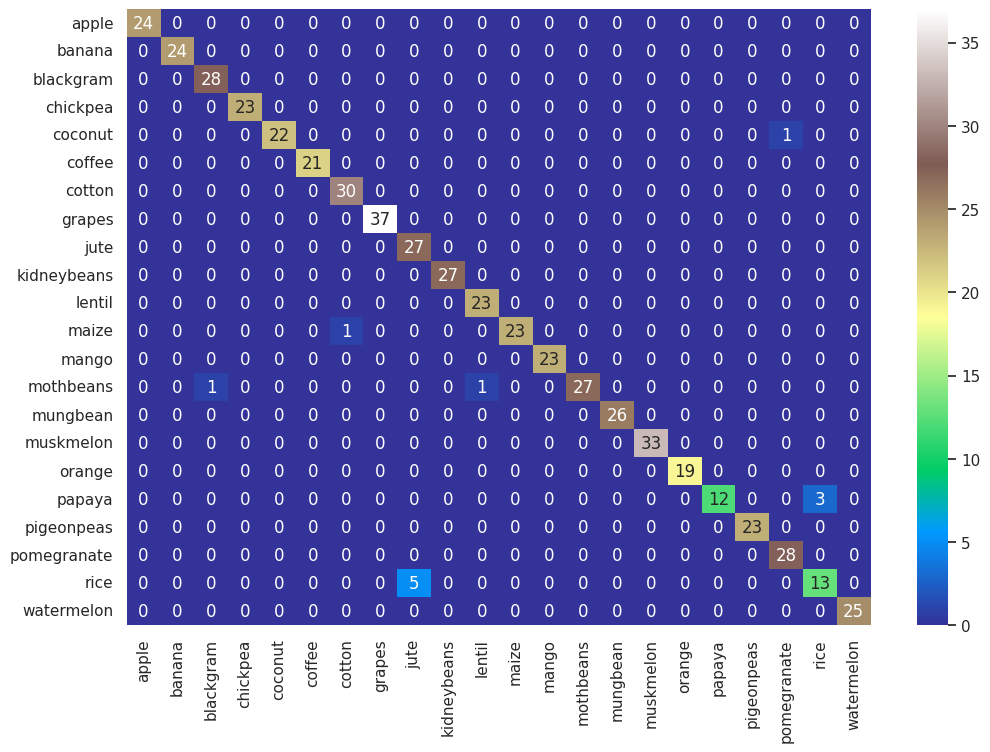

In [25]:
# Building a more complex neural network model in Keras
model = keras.Sequential([
    layers.InputLayer(input_shape=(X_train_scaled.shape[1],)), # Input layer
    layers.Dense(128, activation='relu'), # First hidden layer
    layers.BatchNormalization(),          # Batch Normalization
    layers.Dropout(0.3),                  # Dropout layer
    
    layers.Dense(64, activation='relu'),  # Second hidden layer
    layers.BatchNormalization(),          # Batch Normalization
    layers.Dropout(0.3),                  # Dropout layer
    
    layers.Dense(32, activation='relu'),  # Third hidden layer
    layers.BatchNormalization(),          # Batch Normalization
    layers.Dropout(0.3),                  # Dropout layer
    
    layers.Dense(16, activation='relu'),  # Fourth hidden layer
    
    layers.Dense(len(targets), activation='softmax') # Output layer
])

# Compile the model with a different optimizer and learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_data=(X_test_scaled, y_test), batch_size=32)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Save the model in .keras format
model.save("complex_crop_recommendation_model.keras")

# Display confusion matrix
mat = confusion_matrix(y_test, np.argmax(model.predict(X_test_scaled), axis=1))
df_cm = pd.DataFrame(mat, list(targets.values()), list(targets.values()))
sns.set(font_scale=1.0)
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap="terrain")

In [28]:
# Define manual test cases (input values)
manual_test_cases = np.array([
    [90, 42, 43, 20.88, 82.005, 6.5, 202],
    [73, 45, 21, 24.60, 73.50, 6.630, 96.59],  
])

# Scale the manual test cases using the saved scaler
manual_test_cases_scaled = scaler.transform(manual_test_cases)

# Make predictions
manual_predictions = np.argmax(model.predict(manual_test_cases_scaled), axis=1)

# Print out the results
print("\nManual Test Cases (unscaled):")
print(manual_test_cases)

print("\nPredicted Labels:")
print([targets[label] for label in manual_predictions])

# Detailed Output for each sample
for i in range(len(manual_test_cases)):
    print(f"Manual Test Case {i+1}:")
    print(f"  Inputs (N, P, K, Temp, Humidity, pH, Rainfall): {manual_test_cases[i]}")
    print(f"  Predicted Crop: {targets[manual_predictions[i]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Manual Test Cases (unscaled):
[[ 90.     42.     43.     20.88   82.005   6.5   202.   ]
 [ 73.     45.     21.     24.6    73.5     6.63   96.59 ]]

Predicted Labels:
['rice', 'maize']
Manual Test Case 1:
  Inputs (N, P, K, Temp, Humidity, pH, Rainfall): [ 90.     42.     43.     20.88   82.005   6.5   202.   ]
  Predicted Crop: rice
Manual Test Case 2:
  Inputs (N, P, K, Temp, Humidity, pH, Rainfall): [73.   45.   21.   24.6  73.5   6.63 96.59]
  Predicted Crop: maize
